# Predicting car fuel efficiency

_Our objective in this notebook is to predict the mpg of a car, given specifications such as weight, cylinder count, etc._

# Table of Contents 
1. [Background](#Background)
2. [Data ingestion](#Data-ingestion)
3. [Data preprocessing](#Data-preprocessing)
4. [Exploratory Data Analysis](#EDA)
5. [Model Training](#Model-Training)
6. [Testing the Model](#Testing-the-Model)
7. [Conclusion](#Conclusion)
8. [Credits](#Credits)

# Background

## Purpose

The automotive industry is extremely competitive. With increasing fuel prices and picky consumers, automobile makers are constantly optimizing their processes to increase fuel efficiency. But, what if you could have a reliable estimator for a car's mpg given some known specifications about the vehicle? Then, you could beat a competitor to market by both having a more desirable vehicle that is also more efficient, reducing wasted R&D costs and gaining large chunks of the market.  

Utilizing machine learning, Cocolevio can help you build prediction models to help you gain an edge over your competitors. 

## Introduction

This notebook uses a public dataset from Kaggle, located [HERE](https://www.kaggle.com/uciml/autompg-dataset). Thanks to the University of California, Irvine and Kaggle for providing this dataset. 

This notebook contains the following columns:
**mpg, cylinders, horsepower, weight, acceleration**, etc., which should all be self-explanatory.  

**Displacement** is the volume of the car's engine, usually expressed in liters or cubic centimeters.  
**Origin** is a discrete value from 1 to 3. This dataset does not describe it beyond that, but for this notebook I assumed 1 to be American-origin vehicle, 2 is European, 3 is Asia/elsewhere.  
**Model year** is given as a decimal number representing the last two digits of the 4-digit year (eg. 1970 is model year = 70). 

Our model in this dataset will be trained on many different cars, and it should give us a good estimate for our unknown car's mpg. Note that some of the values in the dataset are incorrect, so we will be fixing those values as we preprocess the data. 

# Data ingestion

## Initial thoughts

According to others using this dataset, some of the mpg values for the cars are incorrect, meaning that some of our predictions will be off by a large amount, but we shouldn't always trust the listed mpg value. There are also unknown mpg values in the dataset, marked with a '?'. We will need to manually replace these with the correct mpg value.  

While our model is the end result of this notebook, the data analysis section will be incredibly important in visualizing trends without having to use any machine learning techniques.

# Data preprocessing

The purpose of the data preprocessing stage is to minimize potential error in the model as much as possible. Generally, a model is only as good as the data passed into it, and the data preprocessing we do ensures that the model has as accurate a dataset as possible. While we cannot perfectly clean the dataset, we can at least follow some basics steps to ensure that our dataset has the best possible chance of generating a good model.

First, let's check and see null values for this dataset. Null values are empty, useless entries within our dataset that we don't need. If we skip removing null values, our model will be inaccurate as we create "connections" for useless values, rather than focusing all resources onto creating connections for useful values.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("auto-mpg.csv")
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [2]:
print("Presence of null values: " + str(df.isnull().values.any()))

Presence of null values: False


The null values in this dataset are actually marked with a '?', so we will have to manually update the information for them. 

I have manually gone through the dataset and input the missing values for each vehicle. There were 6 '?' rows, so I simply searched the year and model of the car and found the most commonly occurring horsepower.  

In [4]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


The next step of preprocessing would be to categorize the 'car name' column. We can create a new feature based on whether or not diesel was included in the title of the vehicle. Then, in the EDA section, we can see how fuel type affects mpg calculations. 

In [5]:
car_names = df['car name'].tolist()

df['type'] = [1 if "diesel" in element else 0 for element in car_names]
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,type
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,0


Let's check and see the presence of diesel and petrol cars in this dataset. We're also removing the 'car name' column since it doesn't add much value beyond fuel type. 

In [6]:
df.pop('car name')
print(df['type'].value_counts())

0    391
1      7
Name: type, dtype: int64


Now that we've scaled the data and labelled all the categorical features, let's analyze our dataset. 

In [7]:
print("Presence of any null values: " + str(df.isnull().values.any()))

Presence of any null values: False


# EDA

The purpose of EDA is to enhance our understanding of trends in the dataset without involving complicated machine learning models. Oftentimes, we can see obvious traits using graphs and charts just from plotting columns of the dataset against each other.

We've completed the necessary preprocessing steps, so let's create a correlation map to see the relations between different features.

A correlation map (or correlation matrix) is a visual tool that illustrates the relationship between different columns of the dataset. The matrix will be lighter when the columns represented move in the same direction together, and it will be darker when one column decreases while the other increases. Strong spots of light and dark spots in our correlation matrix tell us about the future reliabilty of the model.

We should import Seaborn's heatmap and plot the correlation map for this dataset. 

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()
sns.heatmap(corr)
plt.show()

<Figure size 640x480 with 2 Axes>

There are some strong correlations between each column. For cylinders, displacement, horsepower, and weight, it makes sense that the mpg would be negatively correlated with rising trends in any of the named features. Model year and origin also make sense, since non-American/European countries may contain more fuel-efficient standards due to different fuel prices in those areas. 

Next, we can plot the number of cars based on their origin (US = 1, Asia = 2, Europe = 3). This is important to us because we're assuming that different regions have different fuel efficiency priorities, so our model will be skewed towards the region with the most cars in the dataset.

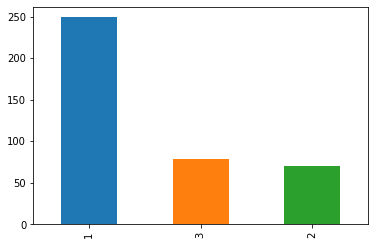

In [9]:
pd.value_counts(df['origin']).plot.bar()

With 1 corresponding to American cars, we can see that the US accounts for the majority of the cars produced here. This may be a problem for our model, but if our accuracy is too low, then we can always normalize the presence of each area in the dataset to get predictions that aren't skewed towards American car mpgs.

We can also view the distributions of different cylinder counts among our dataset.

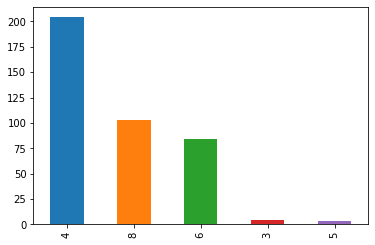

In [10]:
pd.value_counts(df['cylinders']).plot.bar()

Notice how many cars have 4 cylinders versus 8/6 and 3/5. The V3 is an older engine design that was rarely used in production cars, while the V5 counts can be attributed to Volkswagen's VR5 engine design. Since the dataset uses pre-2000s cars, it makes sense how 4 cylinder cars are extremely popular. As time went on, the popularity of the SUV led to more cars having 6-8 cylinders in their engines. 

A boxplot will help us better visualize what is happening with the data. Using seaborn's built-in boxplot method, I've made the plot below, which plots car origin against the mpgs of the individual cars:

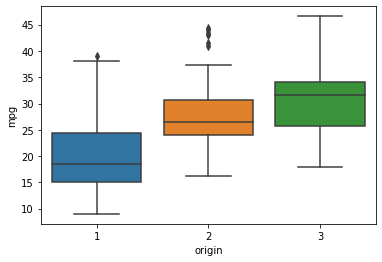

In [11]:
sns.boxplot(x = 'origin', y = 'mpg', data = df)

Before we discuss the box plot, it seems that outliers are affecting our averages, especially for European cars. We can use Python and pandas to see what outliers are present. 

In [12]:
american_cars = df[df['origin'] == 1]
japanese_cars = df[df['origin'] == 3]
european_cars = df[df['origin'] == 2]

quantile_usa = american_cars['mpg'].quantile(0.90)
quantile_jp = japanese_cars['mpg'].quantile(0.90)
quantile_eu = european_cars['mpg'].quantile(0.90)

american_cars[american_cars['mpg'] < quantile_usa]
european_cars[european_cars['mpg'] < quantile_eu]
japanese_cars[japanese_cars['mpg'] < quantile_jp]

frames = [american_cars, european_cars, japanese_cars]
df = pd.concat(frames)
print(len(df.index))

398


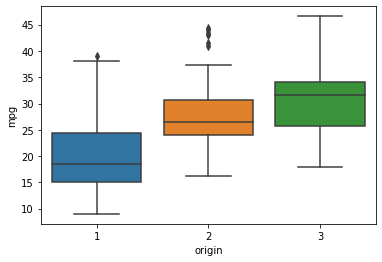

In [13]:
sns.boxplot(x = 'origin', y = 'mpg', data = df)

Remember that USA = 1, Europe = 2, and Asia = 3 for the origin.  

From the boxplot, we can see that the Asian cars often have significantly higher mpg than American/European cars. This may be a contributing factor as to why Japanese cars dominated the automotive industry during that time period. We have done some exploration of our data, now let's try to build our regression model to see how well we can predict the mpg of different vehicles.  

We should also expect that our predicted mpg values will oftentimes be lower than the actual number because of the amount of American cars present within our dataset. We could equalize the distributions of the cars based on region, but doing so would drastically reduce the amount of datapoints we can use, possibly causing problems in our model due to the lack of training data. 

# Model Training

In this section, we will be creating and training our model for predicting what a car's mpg will be. Since there are multiple algorithms we can use to build our model, we will compare the accuracy scores after testing and pick the most accurate algorithm.

Now, let's instatiate our different regression algorithms. Then, we train them and check the accuracy on the training set. 

In [15]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

From this list, we are using XGBoost, DecisionTree, RandomForest, and KNeighborsRegressor to perform our predictions. We will then see which algorithm produces the highest accuracy and select it as our algorithm of choice for future use. We also want to partition our dataset into training, testing, and validation, so let's add a method for that ability.

Let's perform the splitting of our data into test, train, validation using train_test_split.

Our testing will take three phases: testing, training, and validation. Training is first, and it's where our model generates "intuition" about how to approach fraudulent and not fraudulent transactions. It is similar to a student studying and developing knowledge about a topic before an exam.

The testing phase is where we see how the model performs against data where we know the outcome. This would be the exam if we continue the analogy from before. The algorithms will perform differently, similar to how students will score differently on the exam. From this phase, we generate an accuracy score to compare the different algorithms.

The validation testing is how we check that the model isn't overfitting to our specific dataset. Overfitting is when the model starts to develop an intuition that is too specific to the training set. Overfitting is a problem because our model is no longer flexible. It may work on the initial set, but subsequent uses will cause our model to fail. Continuing the exam analogy, the validation testing phase is like another version of the exam with different questions. If a student happened to cheat on the first exam by knowing the questions, the second exam will give a better representation of performance.

Note that verification doesn't completely disprove or prove overfitting, but the testing does give insight about it.

In [14]:
from sklearn.model_selection import train_test_split

training,test = train_test_split(df, train_size = 0.7, test_size = 0.3, shuffle=True)
training, valid = train_test_split(training, train_size = 0.7, test_size =0.3, shuffle=True) 

training_label = training.pop('mpg')
test_label = test.pop('mpg')
valid_label = valid.pop('mpg')

We 'pop' the mpg label as that is what we are trying to predict. Popping simply gives the mpg values as a list, making it easier to use for the accuracy calculations. 

In [16]:
# instantiate training models 
xgb = XGBRegressor()
dtc = DecisionTreeRegressor()
rfc = RandomForestRegressor()
knn = KNeighborsRegressor(n_neighbors=3)

In [17]:
# train the models
xgb.fit(training, training_label)
dtc.fit(training, training_label)
rfc.fit(training, training_label)
knn.fit(training, training_label)

[16:45:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\tgmat\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\tgmat\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
c:\users\tgmat\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

We can now see how our model performs on the testing set and validation set. 

# Testing the Model

Below is the code for testing our mpg model:

In [18]:
xgb_predict = xgb.predict(test)
dtc_predict = dtc.predict(test)
rfc_predict = rfc.predict(test)
knn_predict = knn.predict(test)

Because we are doing regression testing, we use sklearn's built-in mean_squared_error() method and then use math.sqrt() to get the RMSE (root mean squared error). From the RMSE values, we will select the *lowest* number since that algorithm has predicted the closest to the actual value.

In [19]:
from sklearn.metrics import mean_squared_error
import math

accuracy = dict()
accuracy['XGBoost'] = math.sqrt(mean_squared_error(test_label, xgb_predict))
accuracy['DecisionTree'] = math.sqrt(mean_squared_error(test_label, dtc_predict))
accuracy['RandomForest'] = math.sqrt(mean_squared_error(test_label,rfc_predict))
accuracy['KNN'] = math.sqrt(mean_squared_error(test_label,knn_predict))

print(accuracy)

{'XGBoost': 2.7280023689277306, 'DecisionTree': 3.1141076838585184, 'RandomForest': 2.833970124519076, 'KNN': 4.161128541722875}


These results for the testing set match about what others have achieved for this dataset. With some additional fine tuning, we can lower the RMSE even further. Let's run our validation testing, and see what our RMSE values are.

In [20]:
# perform validation testing for dataset
xgb_predict = xgb.predict(valid)
dtc_predict = dtc.predict(valid)
rfc_predict = rfc.predict(valid)
knn_predict = knn.predict(valid)

# judge accuracy using built-in function
accuracy['XGBoost'] = math.sqrt(mean_squared_error(valid_label, xgb_predict))
accuracy['DecisionTree'] = math.sqrt(mean_squared_error(valid_label, dtc_predict))
accuracy['RandomForest'] = math.sqrt(mean_squared_error(valid_label,rfc_predict))
accuracy['KNN'] = math.sqrt(mean_squared_error(valid_label,knn_predict))

print(accuracy)

{'XGBoost': 2.476708401916829, 'DecisionTree': 3.4587879792948115, 'RandomForest': 3.1028122804351295, 'KNN': 4.7391480046020735}


It seems that our model may not be overfitting to our dataset, which is good. While validation testing doesn't completely eliminate the chance of overfitting, it gives us some confidence for when our model handles new data. 

Let's make a DataFrame to view our predicted values versus the actual mpg.

In [21]:
results = pd.DataFrame({'label mpg': valid_label, 
                        'prediction': xgb.predict(valid)})
results.head()

,label mpg,prediction
385,38.0,36.181736
218,36.0,31.440872
256,20.5,20.025846
43,13.0,12.577513
245,36.1,32.260754


From the above table, our model is decently accurate at predicting the mpg of a car. Even though there is some error, generally, it is accurate enough to be reasonable to use for prediction. Even after normalizing the amount of cars per region, the error generally doesn't improve too much. One problem is that the data contains incorrect mpg values for some of the cars. Looking up many of the cars where there is a high error gives vastly different mpg ratings than what is listed in our dataset. Therefore, our model performs very well overall, and big gaps in mpg are usually due to the data itself being incorrect. 

Below is a plot of the performance of the various algorithms:

,Algorithms,Percentage
0,XGBoost,2.476708
1,DecisionTree,3.458788
2,RandomForest,3.102812
3,KNN,4.739148


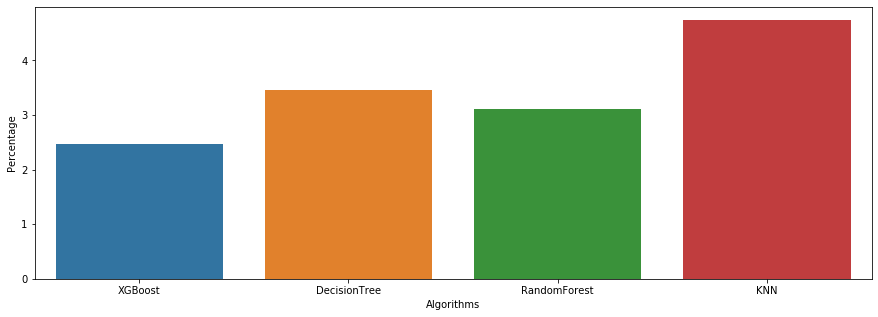

In [22]:
fig, (ax1) = plt.subplots(ncols=1, sharey=True,figsize=(15,5))

new_df=pd.DataFrame(list(accuracy.items()),columns=['Algorithms','Percentage'])
display(new_df)
sns.barplot(x="Algorithms", y="Percentage", data=new_df,ax=ax1);

Again, XGBoost is performing the best, with a RMSE value of 2.5 mpg. While we are picking XGBoost for future predictions, remember that different algorithms tax different resources. If you are prioritizing training speed and have limited memory and CPU time, XGBoost will probably not be the best choice.  

'Best performing' is a very deceptive term for machine learning algorithms because performance can be based on a variety of metrics, such as speed, efficiency, or accuracy. 

Let's select the most accurate algorithm (the smallest RMSE value).

In [23]:
max_accuracy = min(accuracy,key=accuracy.get)

max_accuracy

'XGBoost'

The results tell us that our model is decently reliable for the dataset. Even though some predictions are far away from the actual value, further inspection of the dataset leads me to believe that some of the mpg values are wildly inaccurate. However, we also don't have much data to work with, so I chose to keep the incorrect values and replace the outliers with the actual values as I encounter them. 

# Conclusion

During this notebook, we build a model that could reliably predict a car's mpg given some information about the car within 2.5 mpg of the actual value. This model could be trained with newer car data and be used to predict competitor's future mpg ratings for upcoming cars, allowing you to spend R&D resources on making a more efficient, more popular vehicle to outshine the competitor.  

While our model may be inaccurate in some cases, we talked about how our dataset can contain inaccurate values for the mpg, and oftentimes, our predictions are more accurate than the values in the dataset. For newer cars, the collected data is significantly more reliable, so our model will be able to perform better with a different dataset.  

If you want to optimize spending your resources and outshine the competition, Cocolevio's machine learning models can help you get the edge you need to succeed in your market. 

# Credits

Thanks to the Kaggle community for teaching me a lot of the concepts that I used in this video. 